# TP4 : Classification binaire avec SVM, Mélange de modèles, et Modèles Probabilistes Mixtes

## Exercice 1 : Classification avec SVM

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score , roc_curve , classification_report , accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
import time
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV

In [2]:
file_path = 'spam.csv'
donnes=pd.read_csv(file_path,encoding='latin-1')

1) Prétraitement 


In [3]:
donnes=donnes.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
# on renomme les noms colonnes pour la lisibilités
donnes=donnes.rename(columns={"v1":"Spam_Ham","v2":"sms_corps"})
# pas de valeurs manquantes constaté
# Catégorisation des Spam en '1' et Ham en '1'
donnes['estSpam']=[0 if x=='ham' else 1 for x in donnes['Spam_Ham']]
# On va vectoriser notre texte
vectoriseur= CountVectorizer()
X=vectoriseur.fit_transform(donnes["sms_corps"])
#Cible
y=donnes['estSpam']

2) La stratification est importante pour qu'on puisse tester notre modèle sur des données,on sépare donc nos données en 2 catégories : données d'entrainement et données de test. C'est déconseillé de tester notre modèle sur les données d'entrainement car on risque le 'overfitting'

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=0)

3) Entrainement du modèle SVM avec un noyau linéaire et affichage des résultats

In [ ]:
#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------

svm_line = svm.SVC(random_state=0, probability = True, tol=1e-5)
svm_line.fit(X_train.toarray(),y_train)
pred_line=svm_line.predict(X_test.toarray())
    
#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
# ---------------------------------------------------------------

print("Précision",metrics.precision_score(y_test,pred_line))
print("Rappel",metrics.recall_score(y_test,pred_line))
print("F1 Score",metrics.f1_score(y_test, pred_line))

4) Matrice de confusion et analyse des résultats

In [ ]:
matrice_confusion=metrics.confusion_matrix(y_true=y_test,y_pred=pred_line)
# Visualisation de la matrice de confusion
sns.heatmap(matrice_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.title("Matrice de confusion - SVM avec un noyeau linéaire")
plt.show()


Analyse des résulats, nous avons:
- 1431 Vrai Negatif (TN)
- 3 Faux Negatif (FN)
- 26 Faux Postif (FP)
- 212 True Postif (TP)
Ainsi on a 29 erreurs FN+FP
et 1431+212 = 1643 Bonne prédictions TN + TP
Les erreurs les plus fréquentes sont des Hams qui sont considéré Spam, des mails authentiques considéré comme des spams.

5. Génération et interprétation de la courbe ROC-AUC 

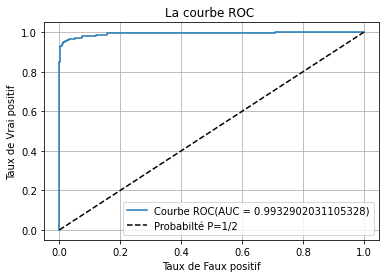

In [53]:
# Score de décisions
decision_scores= svm_line.decision_function(X_test.toarray())

# la courbe ROC ( receiver operating caractéristics
# tpf = Taux faux positif ; tvp = Taux vrai positif ; thresholds  = Seuil
tfp , tvp, thresholds = roc_curve(y_test,decision_scores)

# Faire la partie sous la courbe ( area under curve)
auc=roc_auc_score(y_test,decision_scores) 

# Plot the ROC curve
plt.plot(tfp, tvp, label=f"Courbe ROC(AUC = {auc})")
plt.plot([0, 1], [0, 1], 'k--', label='Probabilté P=1/2')  # Ligne diagonale
plt.xlabel("Taux de Faux positif")
plt.ylabel("Taux de Vrai positif")
plt.title("La courbe ROC ")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Nous avons tracé une courbe aléatoire avec une probabilité 1/2 pour comparer avec notre courbe ROC , un modèle parfait passerait par TVP = 1 , ici on se rapproche mais le modèle de prédiction parfait n'existe pas.
mais on peut remarquer que néanmoins on se rapproche du coin supérieur avec TVP = 1 et TFP = 0 on peut conclure que notre modèles est performant.

## Exercice 2 : Mélange de modèles (Voting Classifier)
1) Créations et entrainement de trois modèles de bases et comparaison des performances

In [54]:
#Création du modèle Naïve Bayes
bayes=GaussianNB()

#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------
bayes.fit(X_train.toarray(),y_train)
pred=bayes.predict(X_test.toarray())

#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
#--------------------------------------------------------------
print("Précision",metrics.precision_score(y_test, pred))
print("Rappel",metrics.recall_score(y_test,pred))
print("F1 Score",metrics.f1_score(y_test, pred,))



Execution Time: 0.7317 seconds
Précision 0.6039325842696629
Rappel 0.9033613445378151
F1 Score 0.7239057239057238


In [55]:
#Création du modèle Régréssion Logistique

#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------
regression_logistique = LogisticRegression()

regression_logistique.fit(X_train,y_train)
pred3=regression_logistique.predict(X_test)


#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
#--------------------------------------------------------------

print("Précision",metrics.precision_score(y_test, pred3))
print("Rappel",metrics.recall_score(y_test,pred3))
print("F1 Score",metrics.f1_score(y_test, pred3,))


Execution Time: 0.0708 seconds
Précision 0.9902439024390244
Rappel 0.8529411764705882
F1 Score 0.9164785553047403


Rappel SVM : 

- Execution Time: 1.5322 seconds
- Précision 0.986046511627907
- Rappel 0.8907563025210085
- F1 Score 0.93598233995585

- Exécution plus rapide : Régression Logistique
- Plus précis : Régression Logistique
- Avec le rappel plus elevé : Naîve Bayes
- Le F1 Score le plus elevé : SVM


2) Combinaison des modèles avec Voting Classifier avec un vote hard (majorité) et Evaluation des performances.

In [56]:

#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------

voting_classifier = VotingClassifier(estimators=[('svm',svm_line),('rl',regression_logistique),('nb',bayes)],voting='hard')
voting_classifier.fit(X_train.toarray(),y_train)
pred_voting = voting_classifier.predict(X_test.toarray())

#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
#--------------------------------------------------------------

print("Précision",metrics.precision_score(y_test,pred_voting ))
print("Rappel",metrics.recall_score(y_test,pred_voting))
print("F1 Score",metrics.f1_score(y_test, pred_voting))


Execution Time: 36.8420 seconds
Précision 1.0
Rappel 0.8529411764705882
F1 Score 0.9206349206349206


il semble avoir une meilleure précision que tous nos modèles précédentes mais dans les autres performances, il est derrière les autres

In [57]:
#Il faut approximer les probabilités en utilisant CalibratedClassifierCV car On a utilisé LinearSVC
# On pourrait aussi utiliser SVC au lieu de LinearSVC

calibrated_svm = CalibratedClassifierCV(svm_line, cv=5)  # cv=5 for cross-validation
calibrated_svm.fit(X_train.toarray(), y_train)

#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------

voting_classifier_soft = VotingClassifier(estimators=[('svm',calibrated_svm),('rl',regression_logistique),('nb',bayes)],voting='soft')
voting_classifier_soft.fit(X_train.toarray(),y_train)
pred_voting_soft = voting_classifier_soft.predict(X_test.toarray())

#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
#--------------------------------------------------------------

print("Précision",metrics.precision_score(y_test,pred_voting_soft ))
print("Rappel",metrics.recall_score(y_test,pred_voting_soft))
print("F1 Score",metrics.f1_score(y_test, pred_voting_soft))

Execution Time: 173.4755 seconds
Précision 1.0
Rappel 0.8907563025210085
F1 Score 0.9422222222222223


La version soft semble être légérement plus performant 

4) La courbe ROC-AUC pour les modèles individuels et le Voting Classifier et Analyse des résultats

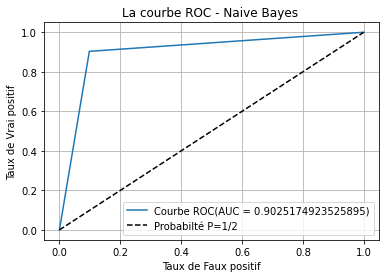

In [59]:
# Score de décisions
decision_scores= bayes.predict_proba(X_test.toarray())[:,1]

# la courbe ROC ( receiver operating caractéristics
# tpf = Taux faux positif ; tvp = Taux vrai positif ; thresholds  = Seuil
tfp , tvp, thresholds = roc_curve(y_test,decision_scores)

# Faire la partie sous la courbe ( area under curve)
auc=roc_auc_score(y_test,decision_scores) 

# Plot the ROC curve
plt.plot(tfp,tvp, label=f"Courbe ROC(AUC = {auc})")
plt.plot([0, 1], [0, 1], 'k--', label='Probabilté P=1/2')  # Ligne diagonale
plt.xlabel("Taux de Faux positif")
plt.ylabel("Taux de Vrai positif")
plt.title("La courbe ROC - Naive Bayes ")
plt.legend(loc="lower right")
plt.grid()
plt.show()

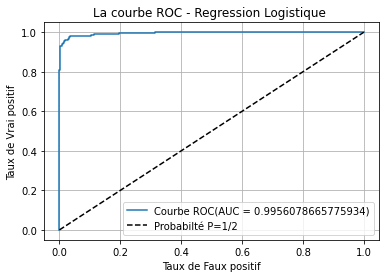

In [60]:
# Score de décisions
decision_scores= regression_logistique.decision_function(X_test.toarray())

# la courbe ROC ( receiver operating caractéristics
# tpf = Taux faux positif ; tvp = Taux vrai positif ; thresholds  = Seuil
tfp , tvp, thresholds = roc_curve(y_test,decision_scores)

# Faire la partie sous la courbe ( area under curve)
auc=roc_auc_score(y_test,decision_scores) 

# Plot the ROC curve
plt.plot(tfp, tvp, label=f"Courbe ROC(AUC = {auc})")
plt.plot([0, 1], [0, 1], 'k--', label='Probabilté P=1/2')  # Ligne diagonale
plt.xlabel("Taux de Faux positif")
plt.ylabel("Taux de Vrai positif")
plt.title("La courbe ROC - Regression Logistique ")
plt.legend(loc="lower right")
plt.grid()
plt.show()

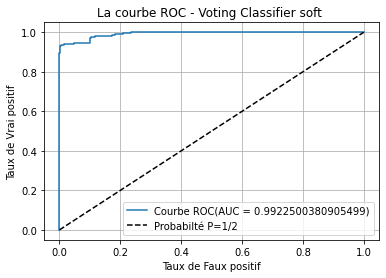

In [61]:
decision_scores= voting_classifier_soft.predict_proba(X_test.toarray())[:,1]

# la courbe ROC ( receiver operating caractéristics
# tpf = Taux faux positif ; tvp = Taux vrai positif ; thresholds  = Seuil
tfp , tvp, thresholds = roc_curve(y_test,decision_scores)

# Faire la partie sous la courbe ( area under curve)
auc=roc_auc_score(y_test,decision_scores) 

# Plot the ROC curve
plt.plot(tfp, tvp, label=f"Courbe ROC(AUC = {auc})")
plt.plot([0, 1], [0, 1], 'k--', label='Probabilté P=1/2')  # Ligne diagonale
plt.xlabel("Taux de Faux positif")
plt.ylabel("Taux de Vrai positif")
plt.title("La courbe ROC - Voting Classifier soft ")
plt.legend(loc="lower right")
plt.grid()
plt.show()

Ils ont un peu près les mêmes performances dans notre cas.

5) Le mélange des modèles peuvent surpasser les modèles individuels car :
  - Les erreurs peuvent être attenués car on combine plusieurs modèles
  - Certains modèles sont performants sur certains domaines, donc une combinaison donneras des meilleurs résultats
  - Moins de variances des resultats due au surapprentissage donc un modèle plus solide et fiable

## Exercice 3 : Classification avec Gaussian Mixture Models (GMM)

1) Explication du principe des Gaussian Mixture Modeles et leur rôle dans la classification:

    - Un mélange de plusieurs distributions normales ( combinaisaon pondérée de gaussiennes)
    - Utilise l'algorithme EM ( Expectation Maximization) 
    - Utilisé dans l'apprentissage non supervisée pour le clustering
    - Utilisé dans l'apprentissage supervisée pour la classification probabiliste
      
2) Implémentation d'un modèle GMMsur des données vectorisées ( 2 classes ) et entrainement surl'ensemble d'entrainement

In [62]:
#calcul temps d'exécution -------------------------------------
start_time = time.time()
#--------------------------------------------------------------

gmm = GaussianMixture(n_components=2,random_state=69)
gmm.fit(X_train.toarray()) 
gmm_pred = gmm.predict(X_test.toarray())


#calcul temps d'exécution -------------------------------------
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")
#--------------------------------------------------------------

print("Précision",metrics.precision_score(y_test,gmm_pred ))
print("Rappel",metrics.recall_score(y_test,gmm_pred))
print("F1 Score",metrics.f1_score(y_test, gmm_pred))

Execution Time: 69.7720 seconds
Précision 0.6136363636363636
Rappel 0.1134453781512605
F1 Score 0.19148936170212763


In [65]:
models = {
    'SVM':pred_line,
    'Voting Hard' : pred_voting,
    'Voting Soft' : pred_voting_soft,
    'Gaussian Mixture' : gmm_pred,
    'Naives Bayes' : pred,
    'Regression Logistique' : pred3
}

for name, predictions in models.items():
    print(f"Performance de {name}:")
    print(metrics.classification_report(y_test,predictions))

Performance de SVM:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1434
           1       1.00      0.82      0.90       238

    accuracy                           0.97      1672
   macro avg       0.99      0.91      0.94      1672
weighted avg       0.97      0.97      0.97      1672

Performance de Voting Hard:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1434
           1       1.00      0.85      0.92       238

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.95      1672
weighted avg       0.98      0.98      0.98      1672

Performance de Voting Soft:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1434
           1       1.00      0.89      0.94       238

    accuracy                           0.98      1672
   macro avg       0.99      0.95      0.97      167

4) 
Meilleur précision : SVM  pour spam
Meilleur rappel : SVM pour spam
Meilleur F1 - score : Voting Hard / Voting Soft / Regression Logistique : 0.99 pour non spam

5) Tracage des frontières de décision du GMM et explication 

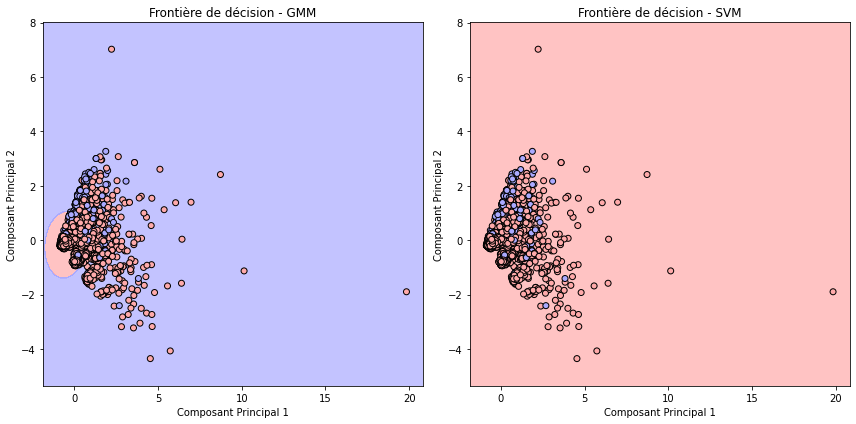

In [76]:
pca = PCA(n_components=2)
X_train_2d= pca.fit_transform(X_train.toarray())
X_test_2d = pca.transform(X_test.toarray())

gmm_2d = GaussianMixture(n_components=2,random_state=69)
gmm_2d.fit(X_train_2d)

svm_2d = SVC(kernel='linear',probability=True)
svm_2d.fit(X_train_2d,y_train)

pred_gmm_2d= gmm_2d.predict(X_test_2d)
pred_svm_2d = svm_2d.predict(X_test_2d)


# Créer un maillage de points dans l'espace 2D
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))


# Tracer la frontière de décision pour GMM
Z_gmm = gmm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_gmm = Z_gmm.reshape(xx.shape)

# Tracer la frontière de décision pour SVM
Z_svm = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z_svm = Z_svm.reshape(xx.shape)

# Créer des couleurs pour les classes
cmap = ListedColormap(['#FFAAAA', '#AAAAFF'])

# Tracer les frontières de décision
plt.figure(figsize=(12, 6))

# Subplot pour GMM
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_gmm, alpha=0.7, cmap=cmap)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cmap, edgecolors='k', marker='o')
plt.title("Frontière de décision - GMM")
plt.xlabel("Composant Principal 1")
plt.ylabel("Composant Principal 2")

# Subplot pour SVM
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_svm, alpha=0.7, cmap=cmap)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=cmap, edgecolors='k', marker='o')
plt.title("Frontière de décision - SVM")
plt.xlabel("Composant Principal 1")
plt.ylabel("Composant Principal 2")

plt.tight_layout()
plt.show()



## Exercice 4 : Optimisation des hyperparamètres

1) Les hyperparamètres permettent d'améliorer les performances d'un SVM,
   nous avons plusieurs paramètres :

   - C(Régularisation) : Contrôle du compromis entre un modèle avec une grande marge d'erreurs d'entrainement et un modèle qui minimise les erreurs d'entraînement.

   - Kernel : Permet de choisir un noyau pour la transformation des données
      - Linéaire
      - Gaussien RBF( Fonction à base radiale)
      - Polynomial
      - Sigmoïde

    - Gamma : Contrôle la portée des données pour les noyaux non linéaires (RBF, Polynomial)
  
    - Degree : Seulement pour le noyau polynomial ( définit le degré du polynôme)

2) Recherche par GridSearchCV pour optimiser les paramètres C et kernel du SVM

In [ ]:
# Définition des hyperparamètres à optimiser
param_grid = {
    'C' : [0.1,1,10,100], # Régularisation
    'kernel' : ['linear','rbf','poly'], # Type de noyau
    'gamma' : ['scale','auto'] # pour poly er rbf
}

#initalisation du SVM

svm=SVC()

grid_search= GridSearchCV(svm,param_grid, cv=5, scoring = 'accuracy', verbose = 1)
grid_search.fit(X_train.toarray(),y_train)

# Afficher les meilleurs paramètres et performances
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleure précision : {grid_search.best_score_:.2f}")

# Évaluer le modèle sur l'ensemble de test
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test.toarray())
print(classification_report(y_test, y_pred))


Output: 
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleur paramètres : {'C': 10, 'gamma' : 'scale', 'kernel':'linear'}
Meilleure précision : 0,98

3) Optimisation des paramètres du Voting Classifier en ajustant les poids attribués à chaque modèle 

In [ ]:
# Définition du Voting Classifier avec des poids comme hyperparamètres
voting_classifier = VotingClassifier(estimators=[
    ('svm', best_svm), 
    ('logistic', regression_logistique), 
    ('naive_bayes', bayes)
], voting='soft')

param_grid_voting = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]]  # On teste avec différentes combinaisons
}

grid_search_voting = GridSearchCV(voting_classifier, param_grid_voting, cv=5, scoring='accuracy', verbose=1)
grid_search_voting.fit(X_train.toarray(), y_train)

# Meilleurs poids et performances
print(f"Meilleurs poids : {grid_search_voting.best_params_}")
print(f"Meilleure précision : {grid_search_voting.best_score_:.2f}")


4) Implémentation d'une optimisation des paramètres du GMM et Evaluation des performances du modèle optimisé ( impossible de lancer sur mon ordi)
5) L'optimisation est très intensive en termes de ressources

## Exercice 5

1) Si on compare les performances selon la précision,rappel,F1-score,AUC-ROC:
   - SVM :
         - Meilleur sur des problèmes de classification aux fronitères complexes et avec un noyau RBF
         - Bon score de précision et F1-score
     
   - GMM :
         - Moins performant que les autres modèles car il n'est pas concu pour ce genre de problème
         - Peut donner un bon AUC-ROC
  
     - Voting Classifier :
           - Utilise les forces de chaque modèles à l'intérieur pour avoir de meilleurs performance
           - Equilibre les faiblesses des autres modèles, donc plus robuste et fiable

2) Comparaison de la complexités des modèles :
    - SVM :
          - Complexité elevés dependant de la taille des données
          - Temps d'entrainement elevés
          - Besoin d'une mémoire importante pour stocker les resultats
      
     - GMM:
          - Complexité elevé dependant du nombre de composant et dimension des données
          - Elle peut être couteux en ressource selon les composants et dimensionnalité

     - Voting Classifier :
          - Complexité depend des modèles qu'il dispose
          - Temps d'entrainement depend des modèles, c'est l'addition du temps d'entrainement des modèles

3) Voting Classifier serait préférable à un GMM ou SVM:

    - dans le cas où on est pas sur de savoir quel modèles seront efficace, Si juste GMM ou SVM n'est pas assez performant.
    - Caractèristiques mixtes des données ( linéare + non linéaires par exemple)
    - Permet d'équilibrer les resultats obtenus si un modèle produit des résultats pas performant , il est compensé par les autres

4) Avantages et limites :
        - SVM :
            - Avantages : - Performant quand les données sont petites avec des frontière complexes.
                          - Adapté si peu de bruit
   
            - Limites : - Lent sur grandes données
                        - Peu être inefficaces si les hyperparamètres sont mauvais et si les données sont pas normalisés

   
  
        - GMM :
            - Avantages : - Flexible pour modèliser des données non linéaires ou distribuées de manière complexe

                          - Utile pour le clustering non supervisé 
            - Limites : - Pas performant pour du supervisé 


        - Voting Classifiers :
            - Avantages : - Utilise les forces des modèles qu'il utilise
                          - Bias réduit et robuste du aux fait des resultats des modèles qui s'équilibrent
 
            - Limites : - Plus complexe à utiliser et optimiser
                        - Dépendant des modèles et des leurs performances

5) On pourrait utiliser un Voting CLassifier avec un SVM pour les frontières , GMM pour modèliser les distribution non linéaires, la regréssion logistique pour les relations simple.        
